In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from networkx.algorithms import approximation
import matplotlib.pyplot as plt
from collections import Counter
import warnings
import random
import community

%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
# Read data and convert to graph
facebook = pd.read_csv(
    "facebook_combined.txt.gz",
    compression="gzip",
    sep=" ",
    names=["start_node", "end_node"],
)
G = nx.from_pandas_edgelist(facebook, "start_node", "end_node")
print(G)

Graph with 4039 nodes and 88234 edges


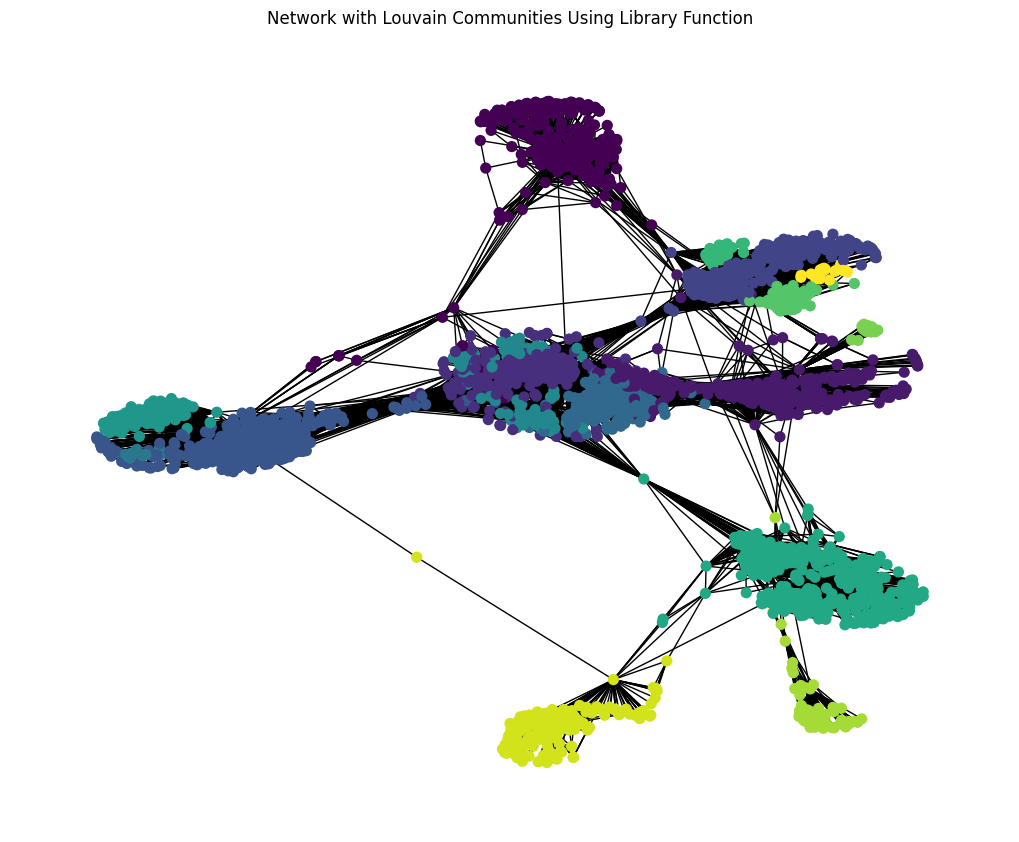

In [3]:
# Apply Louvain algorithm for community detection
partition = community.best_partition(G)

# Visualize the network with communities using matplotlib
pos = nx.spring_layout(G, seed=42)
cmap = plt.get_cmap('viridis')
node_colors = [partition[node] for node in G.nodes]

plt.figure(figsize=(10, 8))
nx.draw(G, pos, node_size=50, node_color=node_colors, cmap=cmap, with_labels=False)
plt.title("Network with Louvain Communities Using Library Function")
plt.show()

# Print the number of communities and their nodes
communities = {}
for node, community_id in partition.items():
    # print (node, community_id)
    if community_id not in communities:
        communities[community_id] = []
    communities[community_id].append(node)

In [4]:
for community_id, nodes in sorted(communities.items()):
    print(f"Community {community_id}: {len(nodes)} nodes")
    # print(nodes)

Community 0: 354 nodes
Community 1: 430 nodes
Community 2: 442 nodes
Community 3: 423 nodes
Community 4: 535 nodes
Community 5: 325 nodes
Community 6: 19 nodes
Community 7: 117 nodes
Community 8: 226 nodes
Community 9: 548 nodes
Community 10: 73 nodes
Community 11: 237 nodes
Community 12: 25 nodes
Community 13: 60 nodes
Community 14: 206 nodes
Community 15: 19 nodes


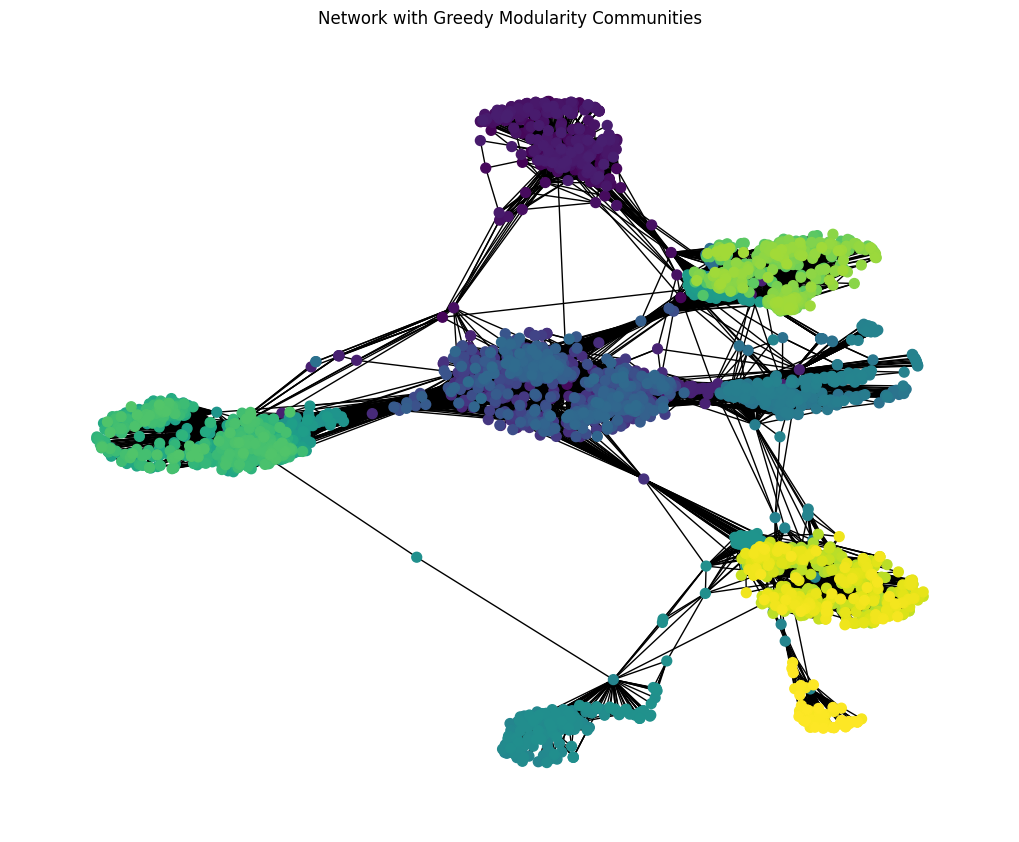

In [5]:
import random

def calculate_modularity(G, communities):
    m = G.number_of_edges()
    modularity = 0.0

    for community in communities:
        subgraph = G.subgraph(community)
        L_c = subgraph.number_of_edges()
        d_c = sum(dict(G.degree(community)).values())
        modularity += (L_c / m) - ((d_c / (2 * m)) ** 2)

    return modularity

def greedy_modularity_community_detection(G, max_iterations=100):
    communities = [set([node]) for node in G.nodes if G.degree(node) > 0]

    for _ in range(max_iterations):
        # Randomly choose two communities to merge
        community1, community2 = random.sample(communities, 2)

        # Calculate modularity change after merging
        merged_community = community1.union(community2)
        modularity_before = calculate_modularity(G, communities)
        modularity_after = calculate_modularity(G, communities + [merged_community])

        # If modularity increases, merge the communities
        if modularity_after > modularity_before:
            communities.remove(community1)
            communities.remove(community2)
            communities.append(merged_community)

    return communities


detected_communities = greedy_modularity_community_detection(G)

# Visualize the network with communities using matplotlib
pos = nx.spring_layout(G, seed=42)
cmap = plt.get_cmap('viridis')
node_colors = [i for i, comm in enumerate(detected_communities) for _ in comm]

plt.figure(figsize=(10, 8))
nx.draw(G, pos, node_size=50, node_color=node_colors, cmap=cmap, with_labels=False)
plt.title("Network with Greedy Modularity Communities")
plt.show()

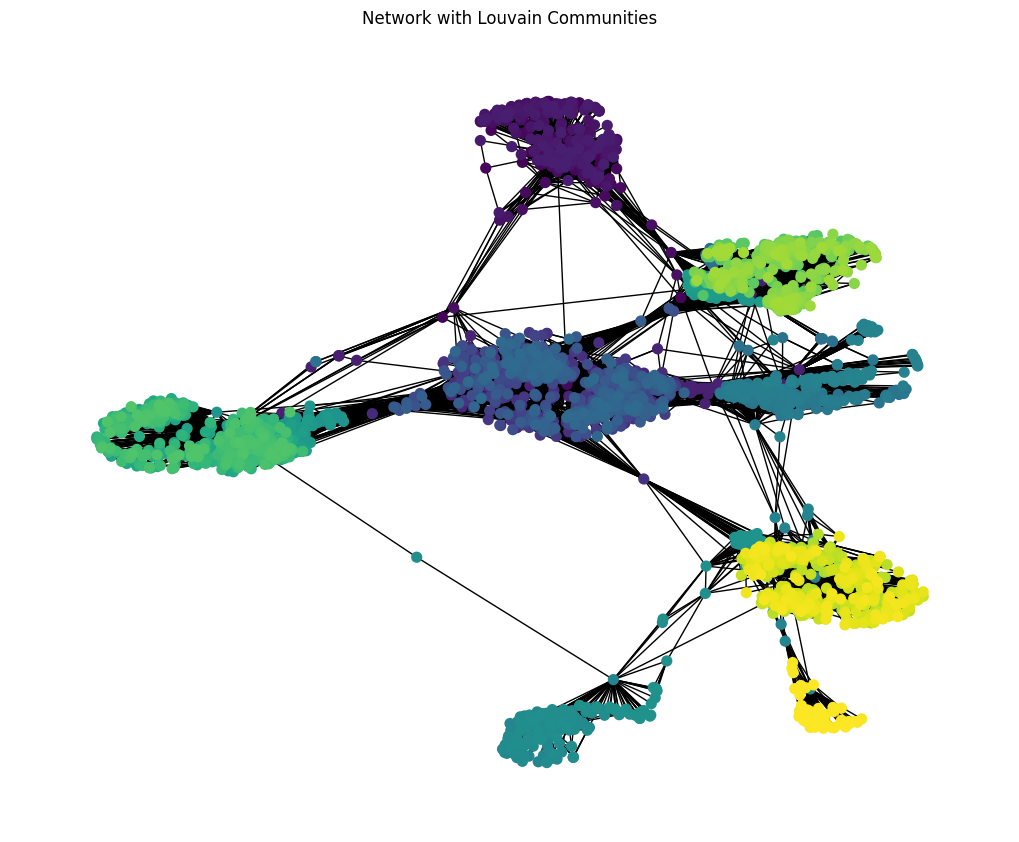

In [6]:
import networkx as nx
import matplotlib.pyplot as plt

def calculate_modularity(G, communities):
    m = G.number_of_edges()
    modularity = 0.0

    for community in communities:
        subgraph = G.subgraph(community)
        L_c = subgraph.number_of_edges()
        d_c = sum(dict(G.degree(community)).values())
        modularity += (L_c / m) - ((d_c / (2 * m)) ** 2)

    return modularity

def louvain_algorithm(G, max_iterations=100, convergence_threshold=1e-5):
    def modularity_gain(node, target_community, current_community):
        return (
            2 * G.degree(node, weight='weight') - sum(G[node][neighbor].get('weight', 1) for neighbor in G.neighbors(node)),
            calculate_modularity(G, [target_community, current_community]) - calculate_modularity(G, [current_community])
        )

    # Initialize each node as a separate community
    communities = [{node} for node in G.nodes]
    iteration = 0

    while iteration < max_iterations:
        improved = False

        for node in G.nodes:
            current_community = next(comm for comm in communities if node in comm)
            neighboring_communities = [comm for comm in G.neighbors(node) if comm in communities]

            if not neighboring_communities:
                continue

            target_community = max(neighboring_communities, key=lambda comm: modularity_gain(node, comm, current_community)[1])

            if modularity_gain(node, target_community, current_community)[0] > 0:
                current_community.remove(node)
                target_community.add(node)
                improved = True

        # Check for convergence
        if not improved:
            break

        iteration += 1

    return communities

# Apply the Louvain algorithm for community detection
detected_communities = louvain_algorithm(G, max_iterations=100, convergence_threshold=1e-5)

# Visualize the network with communities using matplotlib
pos = nx.spring_layout(G, seed=42)
cmap = plt.get_cmap('viridis')
node_colors = [i for i, comm in enumerate(detected_communities) for _ in comm]

plt.figure(figsize=(10, 8))
nx.draw(G, pos, node_size=50, node_color=node_colors, cmap=cmap, with_labels=False)
plt.title("Network with Louvain Communities")
plt.show()


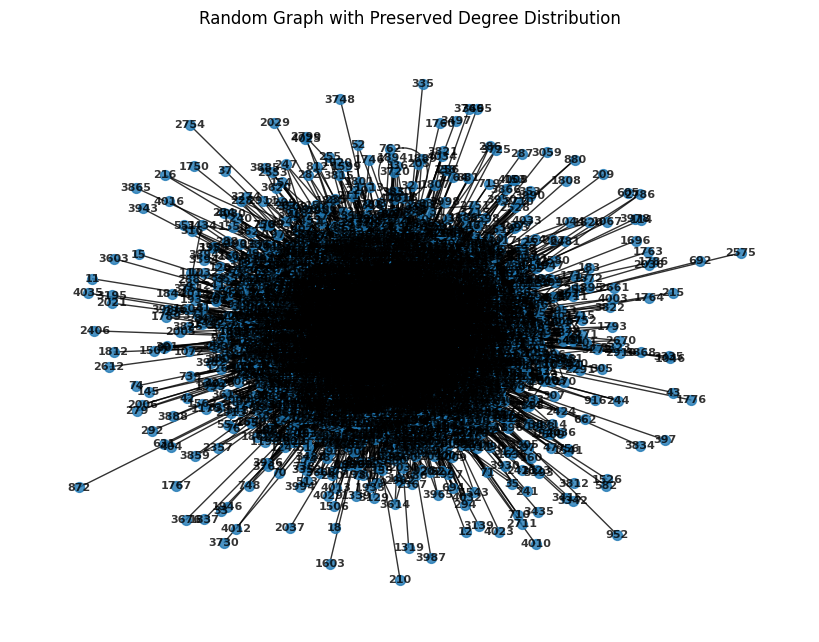

In [7]:
# Hypothesis Testing
# (H1)
original_graph = G

# Null Model (H0)
# Configuration model to preserve the degree distribution
degree_sequence = [d for n, d in original_graph.degree()]
random_graph = nx.configuration_model(degree_sequence, seed=42)

# Remove parallel edges and self-loops
random_graph = nx.Graph(random_graph)

# Visualize the random graph
pos = nx.spring_layout(random_graph, seed=42)
plt.figure(figsize=(8, 6))
nx.draw(random_graph, pos, with_labels=True, node_size=50, alpha=0.8, font_size=8, font_color="black", font_weight="bold")
plt.title("Random Graph with Preserved Degree Distribution")
plt.show()


In [8]:
# Comparing Modularity for Random Graph (Null Model) and Original Graph
H0_partition = community.best_partition(random_graph)
H1_partition = community.best_partition(original_graph)

H0_modularity = community.modularity(H0_partition, random_graph)
H1_modularity = community.modularity(H1_partition, original_graph)

print(f"Modularity of Random Graph: {H0_modularity}")
print(f"Modularity of Original Graph: {H1_modularity}")

Modularity of Random Graph: 0.11808254747809001
Modularity of Original Graph: 0.8348853005941133


Text(0.5, 1.0, 'Cut Ratio for Each Community')

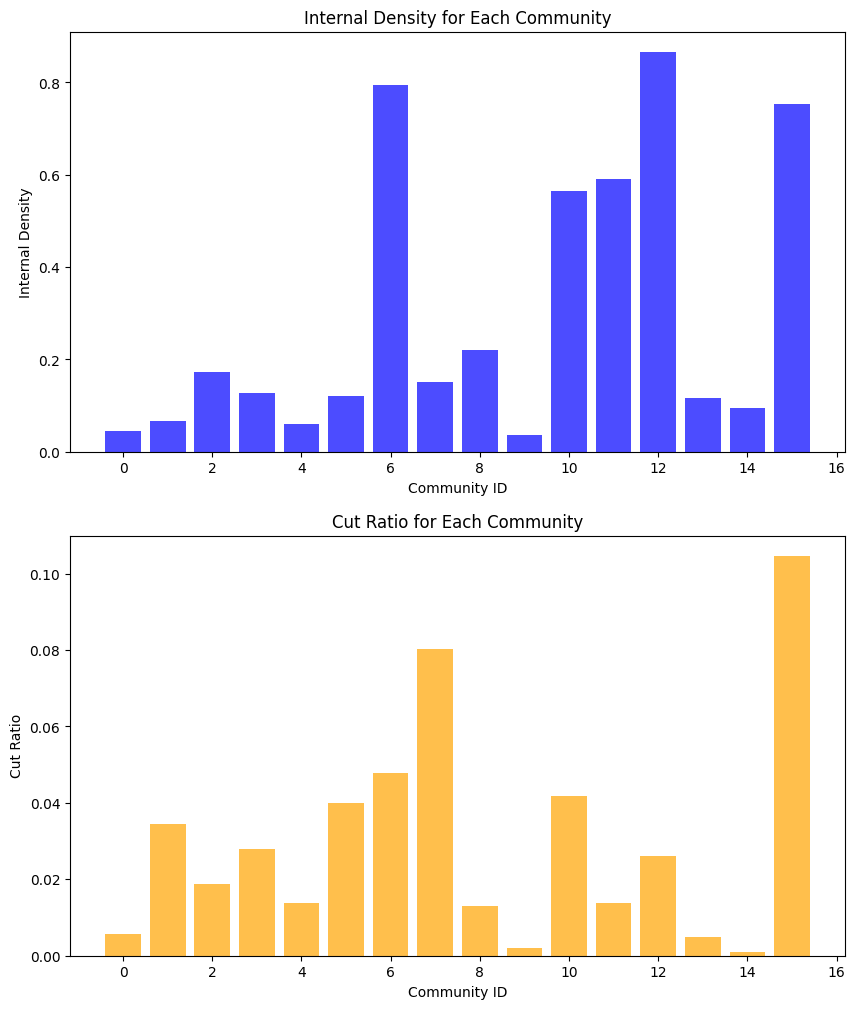

In [9]:
community_ids = list(communities.keys())
internal_densities = []
cut_ratios = []
community_info = []


for community_id, community_nodes in communities.items():
    # Subgraph representing the community
    community_subgraph = G.subgraph(community_nodes)
    
    # Calculate internal density
    internal_density = nx.density(community_subgraph)
    internal_densities.append(internal_density)
    
    # Calculate cut ratio
    cut_ratio = nx.cut_size(G, community_nodes) / (2 * internal_density * len(community_nodes) * (len(community_nodes) - 1))
    cut_ratios.append(cut_ratio)

    # Store community information
    community_info.append({
        'community_id': community_id,
        'internal_density': internal_density,
        'cut_ratio': cut_ratio
    })
    
    # print(f"Community {community_id} - Internal Density: {internal_density}, Cut Ratio: {cut_ratio}")

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(10, 12))

# Bar plot for Internal Density
ax[0].bar(community_ids, internal_densities, color='blue', alpha=0.7)
ax[0].set_ylabel('Internal Density')
ax[0].set_xlabel('Community ID')
ax[0].set_title('Internal Density for Each Community')

# Bar plot for Cut Ratio
ax[1].bar(community_ids, cut_ratios, color='orange', alpha=0.7)
ax[1].set_ylabel('Cut Ratio')
ax[1].set_xlabel('Community ID')
ax[1].set_title('Cut Ratio for Each Community')

In [10]:
# Sort communities based on internal density (highest to lowest)
sorted_communities_density = sorted(community_info, key=lambda x: x['internal_density'], reverse=True)

# Sort communities based on cut ratio (lowest to highest)
sorted_communities_cut_ratio = sorted(community_info, key=lambda x: x['cut_ratio'])

# Print communities based on highest internal density
print("Communities sorted by highest internal density:")
for community in sorted_communities_density:
    print(f"Community {community['community_id']}: Internal Density = {community['internal_density']}")

# Print communities based on lowest cut ratio
print("\nCommunities sorted by lowest cut ratio:")
for community in sorted_communities_cut_ratio:
    print(f"Community {community['community_id']}: Cut Ratio = {community['cut_ratio']}")

Communities sorted by highest internal density:
Community 12: Internal Density = 0.8666666666666667
Community 6: Internal Density = 0.7953216374269005
Community 15: Internal Density = 0.7543859649122807
Community 11: Internal Density = 0.5915397268111278
Community 10: Internal Density = 0.5654490106544902
Community 8: Internal Density = 0.22025565388397247
Community 2: Internal Density = 0.17176101209714656
Community 7: Internal Density = 0.1519304450338933
Community 3: Internal Density = 0.12797328941324101
Community 5: Internal Density = 0.11984805318138651
Community 13: Internal Density = 0.11581920903954802
Community 14: Internal Density = 0.09391427894861473
Community 1: Internal Density = 0.06571258199165175
Community 4: Internal Density = 0.06084217158458469
Community 0: Internal Density = 0.04566188121188841
Community 9: Internal Density = 0.03573573172847249

Communities sorted by lowest cut ratio:
Community 14: Cut Ratio = 0.0008825012607160867
Community 9: Cut Ratio = 0.0021